In [ ]:
!pip install numpy
!pip install pandas
!pip install psycopg2-binary
!pip install sqlalchemy
!pip install tensorflow
!pip install tensorflow-io

# Interacting with Postgres/SQL

In [ ]:
import os
import pandas as pd
import psycopg2
from sqlalchemy import create_engine

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


## Setting up a connection to Postgres

In [ ]:
# Import Postgres settings from file
with open('psql_settings') as file:
    for line in file:
        psql_settings = line[:-1]
        break
# The imported parameters are host address, user and password
psql_h = psql_settings.split(' ')[0].split('=')[1]
psql_u = psql_settings.split(' ')[1].split('=')[1]
psql_p = psql_settings.split(' ')[2].split('=')[1]

In [ ]:
# Create a new database
conn = psycopg2.connect('dbname=postgres '+psql_settings)
conn.set_isolation_level(psycopg2.extensions.ISOLATION_LEVEL_AUTOCOMMIT)
cur = conn.cursor()
cur.execute('create database "bluebikes";')
conn.commit()
cur.close()
conn.close()

In [ ]:
# Create a connection to the bluebikes database and create a test table.
conn = psycopg2.connect('dbname=bluebikes '+psql_settings)
cur = conn.cursor()
cur.execute('create table test (id integer primary key, name varchar);')
conn.commit()
cur.close()
conn.close()

In [ ]:
# Download data from BlueBikes
!mkdir datasets
!wget https://s3.amazonaws.com/hubway-data/202202-bluebikes-tripdata.zip
!wget https://s3.amazonaws.com/hubway-data/202203-bluebikes-tripdata.zip
!wget https://s3.amazonaws.com/hubway-data/current_bluebikes_stations.csv
!unzip ./202202-bluebikes-tripdata.zip -d ./datasets
!unzip ./202203-bluebikes-tripdata.zip -d ./datasets
!mv current_bluebikes_stations.csv ./datasets
!rm 202202-bluebikes-tripdata.zip
!rm 202203-bluebikes-tripdata.zip

In [10]:
# Import bluebikes data as pandas dataframes
paths = ['./datasets/202202-bluebikes-tripdata.csv',
         './datasets/202203-bluebikes-tripdata.csv',
         './datasets/current_bluebikes_stations.csv']
trips_02 = pd.read_csv(paths[0])
trips_03 = pd.read_csv(paths[1])
stations = pd.read_csv(paths[2], header=1)

In [ ]:
# Pandas can communicate with Postgres via sqlalchemy
psql_engine = create_engine('postgresql://{}:{}@{}/bluebikes'.format(
psql_u, psql_p, psql_h))

## Pandas and Postgres

### DataFrame to Postgres

In [ ]:
trips_02.to_sql('trips_02', psql_engine)

460

In [ ]:
trips_03.to_sql('trips_03', psql_engine)

421

In [ ]:
stations.to_sql('stations', psql_engine)

423

### DataFrame from Postgres

In [ ]:
df = pd.read_sql("select * from stations", psql_engine, index_col='index')

In [ ]:
df.head()

,Number,Name,Latitude,Longitude,District,Public,Total docks,Deployment Year
index,,,,,,,,
0,K32015,1200 Beacon St,42.344149,-71.114674,Brookline,Yes,15,2021.0
1,W32006,160 Arsenal,42.364664,-71.175694,Watertown,Yes,11,2021.0
2,A32019,175 N Harvard St,42.363796,-71.129164,Boston,Yes,18,2014.0
3,S32035,191 Beacon St,42.380323,-71.108786,Somerville,Yes,19,2018.0
4,C32094,2 Hummingbird Lane at Olmsted Green,42.288870,-71.095003,Boston,Yes,17,2020.0


In [ ]:
stations.head()

,Number,Name,Latitude,Longitude,District,Public,Total docks,Deployment Year
0,K32015,1200 Beacon St,42.344149,-71.114674,Brookline,Yes,15,2021.0
1,W32006,160 Arsenal,42.364664,-71.175694,Watertown,Yes,11,2021.0
2,A32019,175 N Harvard St,42.363796,-71.129164,Boston,Yes,18,2014.0
3,S32035,191 Beacon St,42.380323,-71.108786,Somerville,Yes,19,2018.0
4,C32094,2 Hummingbird Lane at Olmsted Green,42.288870,-71.095003,Boston,Yes,17,2020.0


## Order of SQL commands

SELECT
-    FROM
-    JOIN (ON)
-    WHERE
-    GROUP BY
-    HAVING

UNION
-    ORDER BY

### SELECT FROM

In [ ]:
# SQL: SELECT columns FROM table LIMIT n;
df1 = pd.read_sql('select "Name", "District" from stations limit 3', psql_engine)
# Pandas equivalent
df2 = stations[['Name', 'District']][0:3]

In [ ]:
df1

,Name,District
0,1200 Beacon St,Brookline
1,160 Arsenal,Watertown
2,175 N Harvard St,Boston


In [ ]:
df2

,Name,District
0,1200 Beacon St,Brookline
1,160 Arsenal,Watertown
2,175 N Harvard St,Boston


### JOIN ON

In [ ]:
conn = psycopg2.connect('dbname=bluebikes '+psql_settings)
cur = conn.cursor()
cur.execute('create table new_0 as select "index", "starttime", "stoptime" from trips_02 limit 3;')
cur.execute('create table new_1 as select "index", "start station latitude" from trips_02 limit 4;')
conn.commit()
cur.close()
conn.close()

In [ ]:
# SQL: SELECT * FROM t1 FULL OUTER JOIN t2 ON t1.column = t2.column;
# t1.column and t2.column need to be present in the final table.
df1 = pd.read_sql('select * from new_0 as t1 join new_1 as t2 on t1.index=t2.index;', psql_engine)
# Pandas equivalent
df2 = pd.concat([trips_02[["starttime","stoptime"]][0:3],
                trips_02[["start station latitude"]][0:4]], axis=1, join="inner")

In [ ]:
df1

,index,starttime,stoptime,index,start station latitude
0,0,2022-02-01 00:01:22.5160,2022-02-01 00:09:00.2370,0,42.361358
1,1,2022-02-01 00:01:39.3630,2022-02-01 00:11:35.5800,1,42.365070
2,2,2022-02-01 00:02:41.5460,2022-02-01 00:18:08.8330,2,42.354659


In [ ]:
df2

,starttime,stoptime,start station latitude
0,2022-02-01 00:01:22.5160,2022-02-01 00:09:00.2370,42.361358
1,2022-02-01 00:01:39.3630,2022-02-01 00:11:35.5800,42.365070
2,2022-02-01 00:02:41.5460,2022-02-01 00:18:08.8330,42.354659


In [ ]:
# SQL: SELECT * FROM t1 JOIN t2 ON t1.column = t2.columnl;
df1 = pd.read_sql('select * from new_0 as t1 full outer join new_1 as t2 on t1.index=t2.index;', psql_engine)
# Pandas equivalent
df2 = pd.concat([trips_02[["starttime","stoptime"]][0:3],
                trips_02[["start station latitude"]][0:4]], axis=1, join="outer")

In [ ]:
df1

,index,starttime,stoptime,index,start station latitude
0,0.0,2022-02-01 00:01:22.5160,2022-02-01 00:09:00.2370,0,42.361358
1,1.0,2022-02-01 00:01:39.3630,2022-02-01 00:11:35.5800,1,42.365070
2,2.0,2022-02-01 00:02:41.5460,2022-02-01 00:18:08.8330,2,42.354659
3,NaN,None,None,3,42.361358


In [ ]:
df2

,starttime,stoptime,start station latitude
0,2022-02-01 00:01:22.5160,2022-02-01 00:09:00.2370,42.361358
1,2022-02-01 00:01:39.3630,2022-02-01 00:11:35.5800,42.365070
2,2022-02-01 00:02:41.5460,2022-02-01 00:18:08.8330,42.354659
3,NaN,NaN,42.361358


https://www.codeproject.com/Articles/33052/Visual-Representation-of-SQL-Joins

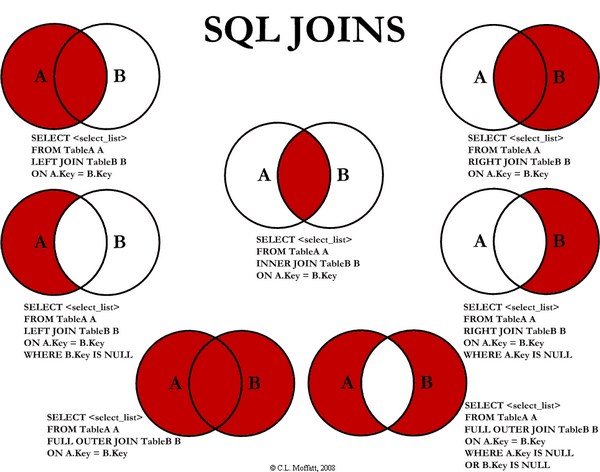

### WHERE

In [ ]:
# SQL: SELECT * FROM table WHERE table.column <> x;
df1 = pd.read_sql('select * from stations where "Total docks">20;', psql_engine)
# Pandas equivalent
df2 = stations[stations["Total docks"]>20]

In [ ]:
df1.head(3)

,index,Number,Name,Latitude,Longitude,District,Public,Total docks,Deployment Year
0,6,M32026,359 Broadway - Broadway at Fayette Street,42.370803,-71.104412,Cambridge,Yes,23,2013.0
1,10,M32054,699 Mt Auburn St,42.375002,-71.148716,Cambridge,Yes,24,2018.0
2,15,M32058,84 Cambridgepark Dr,42.393600,-71.143941,Cambridge,Yes,27,2018.0


In [ ]:
df2.head(3)

,Number,Name,Latitude,Longitude,District,Public,Total docks,Deployment Year
6,M32026,359 Broadway - Broadway at Fayette Street,42.370803,-71.104412,Cambridge,Yes,23,2013.0
10,M32054,699 Mt Auburn St,42.375002,-71.148716,Cambridge,Yes,24,2018.0
15,M32058,84 Cambridgepark Dr,42.393600,-71.143941,Cambridge,Yes,27,2018.0


### GROUP BY

In [ ]:
# SQL: SELECT column1, fn(column2) FROM table GROUP BY column1;
# Need an aggregate function fn (sum, max, count, ...)
df1 = pd.read_sql('select sum("Total docks"), "Deployment Year" from stations group by "Deployment Year";', psql_engine)
# Pandas equivalent
df2 = stations.groupby(by=["Deployment Year"]).sum()["Total docks"]

In [ ]:
df1[df1["Deployment Year"] == 2019.0]

,sum,Deployment Year
0,1053.0,2019.0


In [ ]:
df2[df2.index == 2019.0]

Deployment Year
2019.0    1053
Name: Total docks, dtype: int64

### HAVING

In [ ]:
# SQL: SELECT column1, fn(column2) FROM table GROUP BY column1 HAVING fn(column2)=x;
# Need an aggregate function fn (sum, max, count, ...)
df1 = pd.read_sql('select sum("Total docks"), "Deployment Year" from stations group by "Deployment Year" having sum("Total docks")=1053;', psql_engine)
# Pandas equivalent
df2 = stations.groupby(by=["Deployment Year"]).sum()
df2 = df2[df2["Total docks"]==1053]["Total docks"]

In [ ]:
df1

,sum,Deployment Year
0,1053.0,2019.0


In [ ]:
df2

Deployment Year
2019.0    1053
Name: Total docks, dtype: int64

### UNION

In [ ]:
# SQL: SELECT *, column FROM t1 UNION SELECT *, column FROM t2;
# Need an aggregate function fn (sum, max, count, ...)
df1 = pd.read_sql('select *, "starttime" as st from trips_02 union select *, "starttime" as st from trips_03 limit 10;', psql_engine)
# Pandas equivalent
df2 = pd.concat([trips_03, trips_02], axis=0)[:10]

In [ ]:
df1.head(1)

,index,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,postal code,st
0,0,298,2022-03-01 00:00:03.6830,2022-03-01 00:05:01.7310,67,MIT at Mass Ave / Amherst St,42.3581,-71.093198,179,MIT Vassar St,42.355601,-71.103945,6035,Subscriber,02139,2022-03-01 00:00:03.6830


In [ ]:
df2.head(1)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,postal code
0,298,2022-03-01 00:00:03.6830,2022-03-01 00:05:01.7310,67,MIT at Mass Ave / Amherst St,42.3581,-71.093198,179,MIT Vassar St,42.355601,-71.103945,6035,Subscriber,02139


### ORDER BY

In [ ]:
# SQL: SELECT *, column FROM t1 UNION SELECT *, column FROM t2 ORDER BY column DESC;
# Need an aggregate function fn (sum, max, count, ...)
df1 = pd.read_sql('select *, "starttime" as st from trips_02 union select *, "starttime" as st from trips_03 order by "starttime" desc limit 10;', psql_engine)
# Pandas equivalent
df2 = pd.concat([trips_02, trips_03], axis=0).sort_values(by=["starttime"], axis=0, ascending=False)[:10]

In [ ]:
df1.head(1)

,index,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,postal code,st
0,182420,755,2022-03-31 23:59:53.8100,2022-04-01 00:12:29.5810,530,Foley St at Grand Union Blvd,42.393018,-71.080717,235,East Somerville Library (Broadway and Illinois),42.387628,-71.083187,3216,Subscriber,02114,2022-03-31 23:59:53.8100


In [ ]:
df2.head(1)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,postal code
182420,755,2022-03-31 23:59:53.8100,2022-04-01 00:12:29.5810,530,Foley St at Grand Union Blvd,42.393018,-71.080717,235,East Somerville Library (Broadway and Illinois),42.387628,-71.083187,3216,Subscriber,02114
